Ideas to be taken into account at the customer value score set up:

- **Timedeltas between a Lead_PS_ID-order and the next one**
- **Customer monetary value over time within a time window**
- **Lifetime ranges**
- **PG3-PG4 timeseries**
- **Orders and devices**
- **NL as the ability to get in touch with the customer**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

## First steps

### Data loading

In [2]:
data = pd.read_csv('es_shop_orders_1_year_v2.dsv', sep=';', low_memory=False)

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510374 entries, 0 to 4510373
Data columns (total 20 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AS_ID                       int64
AS_PS_ID                        int64
SCM_AP_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
PP_ID                           float64
PG_ID                           float64
PG4_PARENT_ID                   float64
PG3_PARENT_ID                   float64
PG2_PARENT_ID                   float64
PP_NAME                         object
dtypes: float64(5), int64(8), object(7)
memory usage: 688.2+ MB


In [4]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,SCM_AS_ID,AS_PS_ID,SCM_AP_ID,SCM_MASTER_AP_ID,OSP_KO_COUNT_NET,PP_ID,PG_ID,PG4_PARENT_ID,PG3_PARENT_ID,PG2_PARENT_ID,PP_NAME
0,483939259,113844742,30/06/2018 00:00,14:18,20436070,"39,99","13,0545","9,2371","36,3545",2343801,538165,77230,77230,4,54383.0,2351.0,1310.0,251.0,2.0,Bozita Puppy & Junior weizenfrei
1,476369602,111954242,03/06/2018 00:00,12:54,3174088,"44,99","20,34","14,2103","40,9",2345296,678392,78100,78100,50,54712.0,2351.0,1310.0,251.0,2.0,Bozita Original Weizenfrei
2,476369599,111954242,03/06/2018 00:00,12:54,3174088,"25,99","8,4473","3,2873","23,6273",2343908,538090,77408,77408,50,54471.0,2351.0,1310.0,251.0,2.0,Bozita Original Mini
3,475005728,111613689,29/05/2018 00:00,11:16,19154430,"39,99","12,9345","4,9378","36,3545",2343801,538165,77230,77230,3,54383.0,2351.0,1310.0,251.0,2.0,Bozita Puppy & Junior weizenfrei
4,474255888,111430755,26/05/2018 00:00,17:50,6730517,"12,995","4,2136","2,6674","11,8136",2343908,538090,77408,77408,11,54471.0,2351.0,1310.0,251.0,2.0,Bozita Original Mini


#### Formatting & processing: get Lead PS per order, basket value per order

In [5]:
data[['PP_ID', 'PG_ID', 'PG4_PARENT_ID', 'PG3_PARENT_ID', 'PG2_PARENT_ID']] = data[['PP_ID', 'PG_ID', 'PG4_PARENT_ID', 'PG3_PARENT_ID', 'PG2_PARENT_ID']].fillna(0).astype(int)

In [6]:
def get_date(x):
    return x.split(' ')[0]

In [7]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [8]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format='%d/%m/%Y')

In [9]:
data['ORDER_DATETIME'] = data['TDT_T_KEY_ORDER_DATE'].astype(str) + ' ' + data['THR_C_KEY_ORDER_HOUR'].astype(str) + ':00'

In [10]:
data['ORDER_DATETIME'] = pd.to_datetime(data['ORDER_DATETIME'], 
                                      format="%Y-%m-%d %H:%M:%S")

In [11]:
data['SCM_SALES_BMF'] = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]

In [12]:
data['SCM_D_FINANCE_CM1'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]

In [13]:
data['SCM_D_FINANCE_CM2'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]

In [14]:
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]

In [15]:
data['BASKET_VALUE'] = data['SCM_SALES_BMF'].groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [16]:
data['MAX_SALES_O_POS'] = data['SCM_SALES_BMF'].groupby(data['SCM_N_ORDER_NR']).transform('max')

In [17]:
data['IS_LEAD_PS'] = (data['SCM_SALES_BMF'] == data['MAX_SALES_O_POS']) * 1 * data['AS_PS_ID']

In [18]:
data['LEAD_PS_ID'] = data['IS_LEAD_PS'].groupby(data['SCM_N_ORDER_NR']).transform('max')

In [36]:
#data.to_pickle("./es_data_orders_1_year_v2.pkl")

In [3]:
data = pd.read_pickle("./es_data_orders_1_year_v2.pkl")

In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510374 entries, 0 to 4510373
Data columns (total 25 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AS_ID                       int64
AS_PS_ID                        int64
SCM_AP_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
PP_ID                           int32
PG_ID                           int32
PG4_PARENT_ID                   int32
PG3_PARENT_ID                   int32
PG2_PARENT_ID                   int32
PP_NAME                         object
ORDER_DATETIME                  datetime64[ns]
BASKET_VALUE                    float64
MAX_SALES_O_POS      

#### Get info on PG3, PG4 based on as_id

In [29]:
as_id_to_pg3_pg4 = pd.read_csv('as_id_pg3_pg4.dsv', sep=';', low_memory=False)

In [30]:
as_id_to_pg3_pg4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486201 entries, 0 to 2486200
Data columns (total 4 columns):
AS_ID                     int64
PG3                       int64
PG4                       int64
PG_PRICE_PCT_OVER_PACK    object
dtypes: int64(3), object(1)
memory usage: 75.9+ MB


In [31]:
as_id_to_pg3_pg4['PG_PRICE_PCT_OVER_PACK'] = [float(str(i).replace(',','.')) for i in as_id_to_pg3_pg4['PG_PRICE_PCT_OVER_PACK'].values]

In [32]:
as_id_to_pg3_pg4.sample(10)

,AS_ID,PG3,PG4,PG_PRICE_PCT_OVER_PACK
1901642,1355037,252,35824,1.000
1288725,1628813,409,2230,1.000
456030,2236832,18,394,1.000
2002950,2019514,18,1441,0.865
979031,1650661,251,17798,0.987
804641,1109717,2068,2074,1.000
623343,334667,857,867,1.000
655886,1309995,251,18245,1.000
44679,1579201,18,393,0.049
958020,1055261,2068,2127,1.000


In [33]:
as_id_to_pg3_pg4['AS_ID'].nunique()

2025489

Articles belonging to promos or related have more than one row as they can involve products from different natures...

In [34]:
as_id_to_pg3_pg4[as_id_to_pg3_pg4['AS_ID'] == 639330]

,AS_ID,PG3,PG4,PG_PRICE_PCT_OVER_PACK
944695,639330,857,3314,0.679
2111276,639330,20,96500,0.321


In [35]:
as_id_to_pg3_pg4[as_id_to_pg3_pg4['AS_ID'] == 639330].groupby('AS_ID').agg({'PG3': 'unique',
                                                                            'PG4': 'unique',
                                                                            'PG_PRICE_PCT_OVER_PACK': 'unique'})

,PG3,PG4,PG_PRICE_PCT_OVER_PACK
AS_ID,,,
639330,"[857, 20]","[3314, 96500]","[0.679, 0.321]"


In [36]:
as_id_to_pg3_pg4[as_id_to_pg3_pg4['AS_ID'] == 1944769]

,AS_ID,PG3,PG4,PG_PRICE_PCT_OVER_PACK
368481,1944769,34,1559,0.068
368482,1944769,34,72002,0.037
523397,1944769,252,42545,0.127
523398,1944769,34,71978,0.057
678581,1944769,252,95904,0.102
756553,1944769,36,97982,0.013
834425,1944769,252,201878,0.035
1300183,1944769,2068,9498,0.100
1455998,1944769,2068,3155,0.075
1844562,1944769,301,10331,0.095


In [37]:
#Cannot trace all data within product groups using this approach
as_id_to_pg3_pg4[as_id_to_pg3_pg4['AS_ID'] == 1944769].groupby('AS_ID', as_index=False).agg({'PG3': 'unique',
                                                                            'PG4': 'unique',
                                                                            'PG_PRICE_PCT_OVER_PACK': 'unique'})

,AS_ID,PG3,PG4,PG_PRICE_PCT_OVER_PACK
0,1944769,"[34, 252, 36, 2068, 301]","[1559, 72002, 42545, 71978, 95904, 97982, 2018...","[0.068, 0.037, 0.127, 0.057, 0.102, 0.013, 0.0..."


In [38]:
len(as_id_to_pg3_pg4)

2486201

Let's get those articles having more than one row -involving several PGs-

In [39]:
as_id_to_pg3_pg4_len2 = as_id_to_pg3_pg4['AS_ID'].value_counts()[as_id_to_pg3_pg4['AS_ID'].value_counts() > 1].index.values

In [40]:
type(as_id_to_pg3_pg4_len2[0])

numpy.int64

And split the dataframe using this idea...

In [41]:
as_id_to_pg3_pg4_2 = as_id_to_pg3_pg4[as_id_to_pg3_pg4['AS_ID'].isin(as_id_to_pg3_pg4_len2)]

In [42]:
len(as_id_to_pg3_pg4_2)

911512

In [43]:
as_id_to_pg3_pg4_2['AS_ID'].nunique()

450800

In [44]:
# We create a dictionary with the AS_ID as a key, and all (PG3, PG4, PCT) tuples as the value for those AS_ID with more than one row
as_id_pg3_pg4_dict = {i: [(x, y, z) for x, y, z in list(zip(as_id_to_pg3_pg4_2[as_id_to_pg3_pg4_2['AS_ID'] == i]['PG3'], 
                                                            as_id_to_pg3_pg4_2[as_id_to_pg3_pg4_2['AS_ID'] == i]['PG4'], 
                                                            as_id_to_pg3_pg4_2[as_id_to_pg3_pg4_2['AS_ID'] == i]['PG_PRICE_PCT_OVER_PACK']))]
                      for i in as_id_to_pg3_pg4_2['AS_ID'].unique()}

In [45]:
len(as_id_pg3_pg4_dict)

450800

In [46]:
# Examples
as_id_pg3_pg4_dict[639330]

[(857, 3314, 0.679), (20, 96500, 0.321)]

In [47]:
as_id_pg3_pg4_dict[1944769]

[(34, 1559, 0.068),
 (34, 72002, 0.037),
 (252, 42545, 0.127),
 (34, 71978, 0.057),
 (252, 95904, 0.102),
 (36, 97982, 0.013),
 (252, 201878, 0.035),
 (2068, 9498, 0.1),
 (2068, 3155, 0.075),
 (301, 10331, 0.095),
 (2068, 2127, 0.071),
 (2068, 2072, 0.058),
 (252, 720, 0.163)]

and now let's get the AS_ID with only one row...

In [48]:
as_id_to_pg3_pg4_1 = as_id_to_pg3_pg4[~(as_id_to_pg3_pg4['AS_ID'].isin(as_id_to_pg3_pg4_len2))]

In [49]:
as_id_to_pg3_pg4_len1 = as_id_to_pg3_pg4_1['AS_ID'].unique()

In [50]:
len(as_id_to_pg3_pg4_1)

1574689

In [51]:
as_id_to_pg3_pg4_1['AS_ID'].nunique()

1574689

In [52]:
as_id_to_pg3_pg4_1.sample(5)

,AS_ID,PG3,PG4,PG_PRICE_PCT_OVER_PACK
62668,2070651,2068,55540,1.0
764584,2169991,2068,9498,1.0
794398,795870,20,1426,1.0
1481025,416678,857,864,1.0
1111980,1020945,251,682,1.0


In [53]:
# We build another dict for those
as_id_pg3_pg4_dict_1 = {i: [j] for i, j in list(zip(as_id_to_pg3_pg4_1['AS_ID'], list(zip(as_id_to_pg3_pg4_1['PG3'], 
                                                                    as_id_to_pg3_pg4_1['PG4'], 
                                                                    as_id_to_pg3_pg4_1['PG_PRICE_PCT_OVER_PACK']))))}

In [54]:
# We insert one dict into the other, gathering all info in only one...
as_id_pg3_pg4_dict_1.update(as_id_pg3_pg4_dict)

In [55]:
as_id_pg3_pg4_dict_1[1944769]

[(34, 1559, 0.068),
 (34, 72002, 0.037),
 (252, 42545, 0.127),
 (34, 71978, 0.057),
 (252, 95904, 0.102),
 (36, 97982, 0.013),
 (252, 201878, 0.035),
 (2068, 9498, 0.1),
 (2068, 3155, 0.075),
 (301, 10331, 0.095),
 (2068, 2127, 0.071),
 (2068, 2072, 0.058),
 (252, 720, 0.163)]

In [56]:
#with open('es_as_id_pg3_pg4_dict_of_lists_1.p', 'wb') as fp:
#    pickle.dump(as_id_pg3_pg4_dict_1, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [349]:
#with open('es_as_id_pg3_pg4_dict_1.p', 'wb') as fp:
#    pickle.dump(as_id_pg3_pg4_dict_1, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('es_as_id_pg3_pg4_dict_of_lists_1.p', 'rb') as fp:
    as_id_pg3_pg4_dict_1 = pickle.load(fp)

In [57]:
#Pandas DataFrame
as_id_pg3_pg4_df = pd.DataFrame(columns=['AS_ID', 'PG3_PG4_INFO'])

In [58]:
as_id_pg3_pg4_df['AS_ID'] = list(as_id_pg3_pg4_dict_1.keys())

In [59]:
as_id_pg3_pg4_df['PG3_PG4_INFO'] = list(as_id_pg3_pg4_dict_1.values())

In [60]:
as_id_pg3_pg4_df.sample(10)

,AS_ID,PG3_PG4_INFO
1641772,1227814,"[(2068, 2127, 0.513), (36, 2173, 0.487)]"
1370527,2204856,"[(251, 255, 1.0)]"
235726,2097934,"[(34, 71978, 1.0)]"
1110032,1646721,"[(409, 60757, 1.0)]"
1943193,908921,"[(252, 1520, 0.93), (36, 1551, 0.07)]"
390252,2382541,"[(18, 235914, 1.0)]"
625059,1933169,"[(857, 239513, 1.0)]"
1924232,1978905,"[(857, 860, 0.989), (20, 108, 0.011)]"
170711,1436275,"[(2190, 323, 1.0)]"
970208,1943915,"[(2068, 2332, 1.0)]"


In [61]:
#as_id_pg3_pg4_df.to_pickle("./as_id_pg3_pg4_df.pkl")

In [5]:
as_id_pg3_pg4_df = pd.read_pickle("./as_id_pg3_pg4_df.pkl")

In [7]:
as_id_pg3_pg4_df.sample(5)

,AS_ID,PG3_PG4_INFO
178337,1758790,"[(252, 107608, 1.0)]"
866157,1724946,"[(2068, 3155, 1.0)]"
413130,1267383,"[(34, 71978, 1.0)]"
840606,448191,"[(9, 75, 1.0)]"
2014737,319311,"[(9, 43069, 0.747), (20, 1427, 0.253)]"


#### Merge as_id dataframe and previous data

In [8]:
data = data.merge(as_id_pg3_pg4_df, how='left', left_on='SCM_AS_ID', right_on='AS_ID')

In [9]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4510374 entries, 0 to 4510373
Data columns (total 27 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AS_ID                       int64
AS_PS_ID                        int64
SCM_AP_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
PP_ID                           int32
PG_ID                           int32
PG4_PARENT_ID                   int32
PG3_PARENT_ID                   int32
PG2_PARENT_ID                   int32
PP_NAME                         object
ORDER_DATETIME                  datetime64[ns]
BASKET_VALUE                    float64
MAX_SALES_O_POS      

In [10]:
data['AS_ID'] = data['AS_ID'].fillna(0).astype(int)

In [11]:
data.sample(5)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,SCM_AS_ID,...,PG3_PARENT_ID,PG2_PARENT_ID,PP_NAME,ORDER_DATETIME,BASKET_VALUE,MAX_SALES_O_POS,IS_LEAD_PS,LEAD_PS_ID,AS_ID,PG3_PG4_INFO
4161996,465652600,109269414,2018-04-23,16:05,8817557,25.99,3.8573,-2.2127,23.6273,1883143,...,207553,2,Seresto DOG (ES),2018-04-23 16:05:00,97.97,59.99,0,318838,1883143,"[(207553, 207615, 1.0)]"
4377576,478408173,112473765,2018-06-10,18:20,7552950,0.00,0.0000,0.0000,0.0000,1335593,...,2047,2719,Spende für bedürftige Tiere,2018-06-10 18:20:00,115.41,109.99,0,197251,0,NaN
1937651,421384010,98798603,2017-11-21,08:56,11588002,26.99,10.0058,1.8661,22.3058,1700007,...,3,2719,Sanicat Zen,2017-11-21 08:56:00,114.92,51.96,0,53162,1700007,"[(301, 39682, 1.0)]"
2675792,413630735,96959841,2017-10-24,14:24,13939248,4.99,0.9240,0.5327,4.1240,545999,...,3,2719,Turbinio Katzenspielzeug,2017-10-24 14:24:00,40.19,24.99,0,526277,545999,"[(36, 17752, 1.0)]"
2213707,472760844,111058244,2018-05-21,09:55,10649077,4.69,1.9836,0.8514,4.2636,1956688,...,3,2719,Kattovit Pouches 85 g,2018-05-21 09:55:00,65.31,17.97,0,53597,1956688,"[(2068, 18153, 1.0)]"


#### Save/Load clean df with pickle

In [12]:
#data.to_pickle("./es_data_orders_1_year_complete.pkl")

In [6]:
data = pd.read_pickle("./es_data_orders_1_year_complete.pkl")

In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4510374 entries, 0 to 4510373
Data columns (total 27 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AS_ID                       int64
AS_PS_ID                        int64
SCM_AP_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
PP_ID                           int32
PG_ID                           int32
PG4_PARENT_ID                   int32
PG3_PARENT_ID                   int32
PG2_PARENT_ID                   int32
PP_NAME                         object
ORDER_DATETIME                  datetime64[ns]
BASKET_VALUE                    float64
MAX_SALES_O_POS      

In [8]:
data['O_POS_SALES_SHARE'] = data['SCM_SALES_BMF'] / data['BASKET_VALUE']

Let's replace NaN values in 'PG3_PG4_INFO' column by a list containing a tuple of 3 zeros but they are actually float type while the other elements of the serie are lists...

In [9]:
type(data[data['PG3_PG4_INFO'].isnull()]['PG3_PG4_INFO'].iloc[0])

float

In [10]:
type(data['PG3_PG4_INFO'][0])

list

In [11]:
# Let's create an additional column to verify if changes have been applied without modifying the previous column
data['PG3_PG4_INFO_'] = [[(0, 0, 1)] if type(i) == float else i for i in data['PG3_PG4_INFO'].values]

### Build  customer dict with the relevant info exposed in the intro above and save it as dataframe

In [6]:
data['CUS_N_KEY_CUSTOMER'].nunique()

312306

In [7]:
data['SCM_N_ORDER_NR'].nunique()

1047169

Order-based dictionaries including basket items % per PG3 and PG4 

In [197]:
ord_dict_pg3_basket_perc = {}
ord_dict_pg4_share = {}

for k, i in enumerate(data['SCM_N_ORDER_NR'].unique()):
    ord_data = data[data['SCM_N_ORDER_NR'] == i]
    ord_dict_pg3_basket_perc[i] = sorted([(pg3, np.round(sum([pg_[2] * share_ for share_, pg_info_ in list(zip(ord_data['O_POS_SALES_SHARE'], ord_data['PG3_PG4_INFO_'])) 
                                for pg_ in pg_info_ if pg3==pg_[0]]), 3)) for pg3 in set([pg[0] for share, pg_info in list(zip(ord_data['O_POS_SALES_SHARE'], ord_data['PG3_PG4_INFO_'])) 
                                for pg in pg_info])], key= lambda x: x[1], reverse=True)
    ord_dict_pg4_share[i] = sorted([(pg4, np.round(sum([pg_[2] * share_ for share_, pg_info_ in list(zip(ord_data['O_POS_SALES_SHARE'], ord_data['PG3_PG4_INFO_'])) 
                            for pg_ in pg_info_ if pg4==pg_[1]]), 3)) for pg4 in set([pg[1] for share, pg_info in list(zip(ord_data['O_POS_SALES_SHARE'], ord_data['PG3_PG4_INFO_'])) 
                            for pg in pg_info])], key= lambda x: x[1], reverse=True)
    if k % 100000 == 0:
        print(k)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [199]:
#with open('es_ord_dict_pg3_basket_perc.p', 'wb') as fp:
#    pickle.dump(ord_dict_pg3_basket_perc, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('es_ord_dict_pg3_basket_perc.p', 'rb') as fp:
    ord_dict_pg3_basket_perc = pickle.load(fp)

In [200]:
#with open('es_ord_dict_pg4_share.p', 'wb') as fp:
#    pickle.dump(ord_dict_pg4_share, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('es_ord_dict_pg4_share.p', 'rb') as fp:
    ord_dict_pg4_share = pickle.load(fp)

Aggregate the two previous dictionaries on a customer level

In [207]:
cus_dict_orders_pg3_basket_perc = {}
cus_dict_orders_pg4_share = {}

for k, i in enumerate(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_data_sort_orders = np.sort(data[data['CUS_N_KEY_CUSTOMER'] == i]['SCM_N_ORDER_NR'].unique())
    cus_orders_pg3 = []
    cus_orders_pg4 = []
    
    for j in cus_data_sort_orders:
        cus_orders_pg3.append(ord_dict_pg3_basket_perc[j])
        cus_orders_pg4.append(ord_dict_pg4_share[j])
        
    cus_dict_orders_pg3_basket_perc[i] = cus_orders_pg3
    cus_dict_orders_pg4_share[i] = cus_orders_pg4
    
    if k % 20000 == 0:
        print(k)

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000


In [208]:
cus_dict_orders_pg3_basket_perc[6776459]

[[(301, 1.0), (0, 0.0)],
 [(252, 0.71), (301, 0.29)],
 [(301, 0.312),
  (33, 0.26),
  (252, 0.249),
  (2155, 0.098),
  (29, 0.081),
  (0, 0.0)],
 [(301, 1.0), (0, 0.0)],
 [(252, 0.846), (29, 0.154), (0, 0.0)],
 [(301, 0.519), (251, 0.385), (29, 0.096), (0, 0.0)],
 [(251, 0.517), (252, 0.413), (16, 0.037), (20, 0.033)],
 [(29, 0.608), (301, 0.392), (0, 0.0)],
 [(251, 0.828), (20, 0.112), (18, 0.06)]]

In [209]:
cus_dict_orders_pg4_share[6776459]

[[(39682, 1.0), (0, 0.0)],
 [(683, 0.71), (39682, 0.29)],
 [(39682, 0.312),
  (2180, 0.26),
  (683, 0.249),
  (2157, 0.098),
  (128, 0.081),
  (0, 0.0)],
 [(39682, 1.0), (0, 0.0)],
 [(683, 0.846), (1082, 0.154), (0, 0.0)],
 [(39682, 0.519), (180361, 0.385), (1082, 0.096), (0, 0.0)],
 [(35825, 0.517), (683, 0.413), (97, 0.037), (465, 0.033)],
 [(39925, 0.608), (39682, 0.392), (0, 0.0)],
 [(35825, 0.751),
  (465, 0.085),
  (72745, 0.078),
  (250154, 0.06),
  (96500, 0.028)]]

In [210]:
data[data['CUS_N_KEY_CUSTOMER'] == 6776459]['SCM_N_ORDER_NR'].unique()

array([112272404, 109224231, 103033971,  98287318,  93900133, 107970992,
        92500502, 110491555, 102343249], dtype=int64)

In [211]:
ord_dict_pg3_basket_perc[112272404]

[(251, 0.828), (20, 0.112), (18, 0.06)]

In [212]:
ord_dict_pg4_share[112272404]

[(35825, 0.751), (465, 0.085), (72745, 0.078), (250154, 0.06), (96500, 0.028)]

In [213]:
#with open('es_cus_dict_orders_pg3_basket_perc.p', 'wb') as fp:
#    pickle.dump(cus_dict_orders_pg3_basket_perc, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('es_cus_dict_orders_pg3_basket_perc.p', 'rb') as fp:
    cus_dict_orders_pg3_basket_perc = pickle.load(fp)

In [214]:
#with open('es_cus_dict_orders_pg4_share.p', 'wb') as fp:
#    pickle.dump(cus_dict_orders_pg4_share, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('es_cus_dict_orders_pg4_share.p', 'rb') as fp:
    cus_dict_orders_pg4_share = pickle.load(fp)

Customer-based dictionaries collecting lead_ps for every order, sales values and the order counter

In [28]:
cus_dict_lead_ps = {}
cus_dict_sales = {}
cus_dict_ord_counter = {}

for k, i in enumerate(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == i].groupby('SCM_N_ORDER_NR', as_index=False)[['LEAD_PS_ID',
                                                                                                'BASKET_VALUE',
                                                                                               'OSP_KO_COUNT_NET']].mean()
    cus_data_sort = cus_data.sort_values(by='SCM_N_ORDER_NR')
    cus_dict_lead_ps[i] = list(cus_data_sort['LEAD_PS_ID'].values)
    cus_dict_sales[i] = list(cus_data_sort['BASKET_VALUE'].round(2).values)
    cus_dict_ord_counter[i] = list(cus_data_sort['OSP_KO_COUNT_NET'].values)
    
    if k % 10000 == 0:
        print(k)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000


In [30]:
#with open('es_cus_dict_lead_ps.p', 'wb') as fp:
#    pickle.dump(cus_dict_lead_ps, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open('es_cus_dict_lead_ps.p', 'rb') as fp:
    cus_dict_lead_ps = pickle.load(fp)

In [32]:
#with open('es_cus_dict_sales.p', 'wb') as fp:
#    pickle.dump(cus_dict_sales, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('es_cus_dict_sales.p', 'rb') as fp:
    cus_dict_sales = pickle.load(fp)

In [34]:
#with open('es_cus_dict_ord_counter.p', 'wb') as fp:
#    pickle.dump(cus_dict_ord_counter, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('es_cus_dict_ord_counter.p', 'rb') as fp:
    cus_dict_ord_counter = pickle.load(fp)

Customer-based dictionaries gathering order dates and timedeltas between them

In [ ]:
cus_dict_order_dates = {}
cus_dict_order_timedeltas = {}

for k, i in enumerate(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == i].groupby('SCM_N_ORDER_NR', as_index=False)['TDT_T_KEY_ORDER_DATE'].max().sort_values(by='SCM_N_ORDER_NR')['TDT_T_KEY_ORDER_DATE']
    order_dates_list = list(cus_data.dt.date.values)
    order_timedeltas_days = (cus_data.shift(-1) - cus_data)
    order_timedeltas_list = list(order_timedeltas_days.apply(lambda x:x.days)[:-1].astype(int).values)
    cus_dict_order_dates[i] = order_dates_list
    cus_dict_order_timedeltas[i] = order_timedeltas_list
    if k % 10000 == 0:
        print(k)

In [ ]:
#with open('es_cus_dict_order_dates.p', 'wb') as fp:
#    pickle.dump(cus_dict_order_dates, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
with open('es_cus_dict_order_dates.p', 'rb') as fp:
    cus_dict_order_dates = pickle.load(fp)

In [ ]:
#with open('es_cus_dict_order_timedeltas.p', 'wb') as fp:
#    pickle.dump(cus_dict_order_timedeltas, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('es_cus_dict_order_timedeltas.p', 'rb') as fp:
    cus_dict_order_timedeltas = pickle.load(fp)

In [64]:
cus_dict_lead_ps[16083603]

[239295, 157699, 318840, 219176, 318840, 54742, 54056, 318840, 54055, 318840]

In [65]:
cus_dict_sales[16083603]

[398.6, 132.35, 239.04, 133.57, 152.32, 82.42, 122.2, 148.3, 135.26, 124.58]

In [66]:
cus_dict_ord_counter[16083603]

[3, 4, 5, 6, 7, 8, 10, 11, 11, 12]

In [67]:
cus_dict_order_timedeltas[16083603]

[26, 42, 29, 30, 53, 13, 32, 29, 52]

In [68]:
cus_dict_order_dates[16083603]

[datetime.date(2017, 7, 1),
 datetime.date(2017, 7, 27),
 datetime.date(2017, 9, 7),
 datetime.date(2017, 10, 6),
 datetime.date(2017, 11, 5),
 datetime.date(2017, 12, 28),
 datetime.date(2018, 1, 10),
 datetime.date(2018, 2, 11),
 datetime.date(2018, 3, 12),
 datetime.date(2018, 5, 3)]

**Final framework: customer dictionary with all the info collected before**

In [17]:
cus_dict_info = {}

for i in data['CUS_N_KEY_CUSTOMER'].unique():
    
    cus_dict_info[i] = {}
    cus_dict_info[i]['c_id'] = i
    cus_dict_info[i]['lead_ps_per_order'] = cus_dict_lead_ps[i]
    cus_dict_info[i]['total_sales'] = np.round(sum(cus_dict_sales[i]), 2) # sum values in the customer sales list from the dictionary
    cus_dict_info[i]['orders'] = len(cus_dict_sales[i]) # get the length of the list, one position per order
    cus_dict_info[i]['order_counter'] = cus_dict_ord_counter[i]
    cus_dict_info[i]['orders_info'] = [(x, y) for x, y in zip(cus_dict_lead_ps[i], cus_dict_sales[i])] # sorted tuple (lead lead_ps, sales) 
    cus_dict_info[i]['basket_avg'] = np.round((sum(cus_dict_sales[i]) / len(cus_dict_sales[i])), 2)
    if len(cus_dict_sales[i]) > 1:
        cus_dict_info[i]['basket_std'] = np.round(stdev(cus_dict_sales[i]), 2)
    else:
        cus_dict_info[i]['basket_std'] = 0
    c = Counter(cus_dict_lead_ps[i])
    ord_per_lead_ps = sorted(c.most_common() , key= lambda x: x[0], reverse=True)
    sales_per_lead_ps = sorted([(lead_ps_,sum([sales_ for lead__ps_, sales_ in cus_dict_info[i]['orders_info'] if lead__ps_== lead_ps_])) 
                                         for lead_ps_ in set([lead_ps for lead_ps, sales in cus_dict_info[i]['orders_info']])], key= lambda x: x[0], reverse=True)
    cus_dict_info[i]['lead_ps_ord_sales'] = sorted([(x[0], x[1], y[1]) for x, y in zip(ord_per_lead_ps, sales_per_lead_ps)], key= lambda x: (x[1], x[2]), reverse=True)
    cus_dict_info[i]['main_lead_ps'] = cus_dict_info[i]['lead_ps_ord_sales'][0][0]
    cus_dict_info[i]['main_lead_ps_%_ord'] = np.round((cus_dict_info[i]['lead_ps_ord_sales'][0][1] / cus_dict_info[i]['orders']), 2)
    cus_dict_info[i]['main_lead_ps_%_sales'] = np.round((cus_dict_info[i]['lead_ps_ord_sales'][0][2] / cus_dict_info[i]['total_sales']), 2)
    cus_dict_info[i]['orders_timedeltas'] = cus_dict_order_timedeltas[i]
    cus_dict_info[i]['orders_dates'] = cus_dict_order_dates[i]
    cus_dict_info[i]['orders_pg3_basket_perc'] = cus_dict_orders_pg3_basket_perc[i]
    cus_dict_info[i]['orders_pg4_share'] = cus_dict_orders_pg4_share[i]

In [20]:
#with open('es_shop_cus_dict_info.p', 'wb') as fp:
#    pickle.dump(cus_dict_info, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('es_shop_cus_dict_info.p', 'rb') as fp:
    cus_dict_info = pickle.load(fp)

In [18]:
#Pandas DataFrame
cus_attr = pd.DataFrame.from_dict(cus_dict_info, orient='index').round(2)

In [21]:
#cus_attr.to_pickle("./es_cus_attr.pkl")

### Load customer dataframe from pickle as final framework v1

In [2]:
cus_attr = pd.read_pickle("./es_cus_attr.pkl")

In [117]:
cus_attr.sample(5)

,c_id,lead_ps_per_order,total_sales,orders,order_counter,orders_info,basket_avg,basket_std,lead_ps_ord_sales,main_lead_ps,main_lead_ps_%_ord,main_lead_ps_%_sales,orders_timedeltas,orders_dates,orders_pg3_basket_perc,orders_pg4_share
17034008,17034008,"[53228, 384869, 53228, 300772, 664415, 300772]",256.15,6,"[2, 3, 4, 5, 6, 7]","[(53228, 36.99), (384869, 41.96), (53228, 35.9...",42.69,7.29,"[(300772, 2, 96.22), (53228, 2, 72.98), (66441...",300772,0.33,0.38,"[98, 2, 97, 27, 85]","[2017-07-05, 2017-10-11, 2017-10-13, 2018-01-1...","[[(252, 1.135), (0, -0.135)], [(2068, 0.81), (...","[[(683, 1.135), (0, -0.135)], [(17963, 0.81), ..."
13456937,13456937,"[189753, 318884, 189753]",111.23,3,"[12, 13, 14]","[(189753, 39.27), (318884, 31.98), (189753, 39...",37.08,4.43,"[(189753, 2, 79.25), (318884, 1, 31.98)]",189753,0.67,0.71,"[44, 86]","[2017-07-16, 2017-08-29, 2017-11-23]","[[(251, 0.942), (18, 0.152), (0, -0.094)], [(2...","[[(17798, 0.942), (393, 0.152), (0, -0.094)], ..."
16393376,16393376,"[473915, 473479, 54026, 651884, 54026, 148394]",602.21,6,"[9, 10, 11, 12, 13, 14]","[(473915, 84.36), (473479, 76.61), (54026, 84....",100.37,45.94,"[(54026, 2, 164.85), (148394, 1, 193.96), (473...",54026,0.33,0.27,"[36, 17, 41, 46, 7]","[2017-07-07, 2017-08-12, 2017-08-29, 2017-10-0...","[[(251, 0.676), (18, 0.213), (20, 0.142), (0, ...","[[(31962, 0.676), (104, 0.213), (465, 0.142), ..."
2193850,2193850,"[185448, 621845, 185448, 53476, 185448, 185448...",389.13,7,"[104, 105, 106, 107, 108, 109, 110]","[(185448, 74.15), (621845, 42.63), (185448, 38...",55.59,12.76,"[(185448, 4, 236.04), (53476, 1, 62.0), (48704...",185448,0.57,0.61,"[48, 36, 40, 14, 78, 106]","[2017-07-13, 2017-08-30, 2017-10-05, 2017-11-1...","[[(252, 0.512), (301, 0.324), (2068, 0.161), (...","[[(15418, 0.512), (152946, 0.324), (2632, 0.16..."
6307072,6307072,"[226409, 226409, 226409]",327.70,3,"[19, 20, 21]","[(226409, 132.98), (226409, 102.58), (226409, ...",109.23,21.22,"[(226409, 3, 327.7)]",226409,1.00,1.00,"[172, 154]","[2017-07-24, 2018-01-12, 2018-06-15]","[[(251, 1.053), (0, -0.053)], [(251, 0.955), (...","[[(18245, 1.053), (0, -0.053)], [(18245, 0.955..."


In [5]:
cus_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312306 entries, 72564 to 20607579
Data columns (total 16 columns):
c_id                      312306 non-null int64
lead_ps_per_order         312306 non-null object
total_sales               312306 non-null float64
orders                    312306 non-null int64
order_counter             312306 non-null object
orders_info               312306 non-null object
basket_avg                312306 non-null float64
basket_std                312306 non-null float64
lead_ps_ord_sales         312306 non-null object
main_lead_ps              312306 non-null int64
main_lead_ps_%_ord        312306 non-null float64
main_lead_ps_%_sales      312260 non-null float64
orders_timedeltas         312306 non-null object
orders_dates              312306 non-null object
orders_pg3_basket_perc    312306 non-null object
orders_pg4_share          312306 non-null object
dtypes: float64(5), int64(3), object(8)
memory usage: 40.5+ MB


In [169]:
cus_attr.columns

Index(['c_id', 'lead_ps_per_order', 'total_sales', 'orders', 'order_counter',
       'orders_info', 'basket_avg', 'basket_std', 'lead_ps_ord_sales',
       'main_lead_ps', 'main_lead_ps_%_ord', 'main_lead_ps_%_sales',
       'orders_timedeltas', 'orders_dates', 'orders_pg3_basket_perc',
       'orders_pg4_share'],
      dtype='object')

## Descriptive parameters of latest performance - 1 year -

### Customer monetary value over time within a time window

#### Weighted sales value as a function of time

Gamma distribution is well known for being very flexible. We use this link to find the 
parameters of a gamma dist that suits our needs providing us a non-linear function for weight orders 
depending on how far from now they are. The closer ones obtains greater weights compared to the older. 

http://www.distributome.org/V3/calc/GammaCalculator.html

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
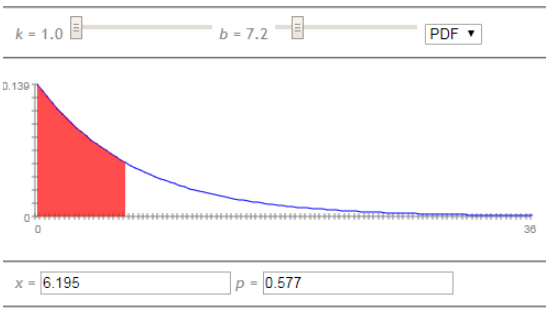

Considering x-axis values as a 10 days slot we got at the last position (36) the days completing almost a year where we assign a probability really close to 0.

In [21]:
from scipy.stats import gamma

In [22]:
shape = 1.0
scale = 7.2
loc = 0

In [23]:
rv = gamma(shape, loc = loc, scale = scale)

In [24]:
 x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)

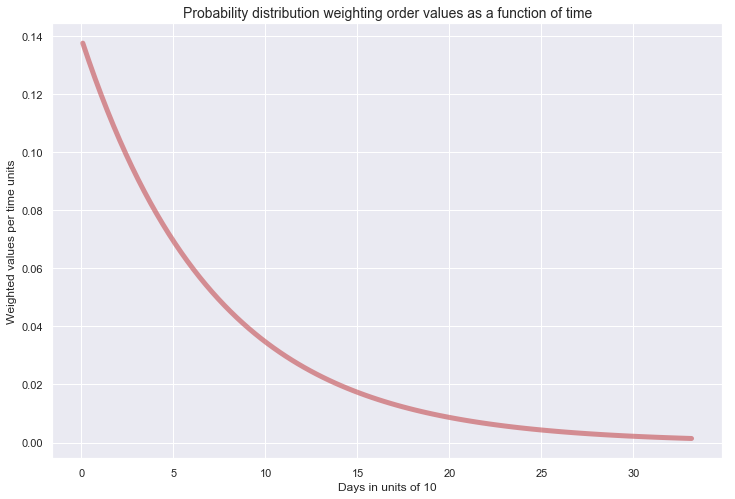

In [25]:
sns.set()
plt.figure(figsize=(12, 8))
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6)
plt.xlabel('Days in units of 10')
plt.ylabel('Weighted values per time units')
plt.title('Probability distribution weighting order values as a function of time', fontsize=14)
plt.show()

In [26]:
weighted_values = [[i * 10 , np.round(8 * rv.pdf(i), 3)] for i in list(range(1, 37))]

That's the final result when multiplying by a factor of 8

In [27]:
weighted_values_df = pd.DataFrame(weighted_values, columns=['days from order date now', 'weight'])
weighted_values_df

,days from order date now,weight
0,10,0.967
1,20,0.842
2,30,0.732
3,40,0.638
4,50,0.555
5,60,0.483
6,70,0.420
7,80,0.366
8,90,0.318
9,100,0.277


In [92]:
#weighted_values_df.to_pickle("./es_weighted_values_df.pkl")

In [ ]:
weighted_values_df = pd.read_pickle("./es_weighted_values_df.pkl")

### Order counter as lifetime ranges

Let's have a look at the histogram showing the order counter for all orders placed in our 1-year time window

In [94]:
counter_list = data.groupby('CUS_N_KEY_CUSTOMER')['OSP_KO_COUNT_NET'].unique().values

In [95]:
flat_order_counter_list = [j for i in counter_list for j in i]

In [149]:
c = Counter(flat_order_counter_list)

In [150]:
c.most_common()

[(1, 127336),
 (2, 76211),
 (3, 61256),
 (4, 52919),
 (5, 47553),
 (6, 43258),
 (7, 39425),
 (8, 36432),
 (9, 33594),
 (10, 31064),
 (11, 28723),
 (12, 26679),
 (13, 24707),
 (14, 23054),
 (15, 21570),
 (16, 20189),
 (17, 18715),
 (18, 17419),
 (19, 16368),
 (20, 15322),
 (21, 14459),
 (22, 13454),
 (23, 12641),
 (24, 11839),
 (25, 11196),
 (26, 10532),
 (27, 9885),
 (28, 9188),
 (29, 8648),
 (30, 8193),
 (31, 7733),
 (32, 7203),
 (33, 6849),
 (34, 6415),
 (35, 6088),
 (36, 5738),
 (37, 5458),
 (38, 5183),
 (39, 4865),
 (40, 4627),
 (41, 4384),
 (42, 4184),
 (43, 3920),
 (44, 3699),
 (45, 3481),
 (46, 3285),
 (47, 3116),
 (48, 2961),
 (49, 2820),
 (50, 2698),
 (51, 2537),
 (52, 2424),
 (53, 2299),
 (54, 2168),
 (55, 2054),
 (56, 1938),
 (57, 1902),
 (58, 1804),
 (59, 1721),
 (60, 1641),
 (61, 1552),
 (62, 1482),
 (63, 1392),
 (64, 1334),
 (65, 1225),
 (66, 1178),
 (67, 1108),
 (68, 1038),
 (69, 990),
 (70, 971),
 (71, 961),
 (72, 912),
 (73, 888),
 (74, 851),
 (75, 840),
 (76, 805),
 (

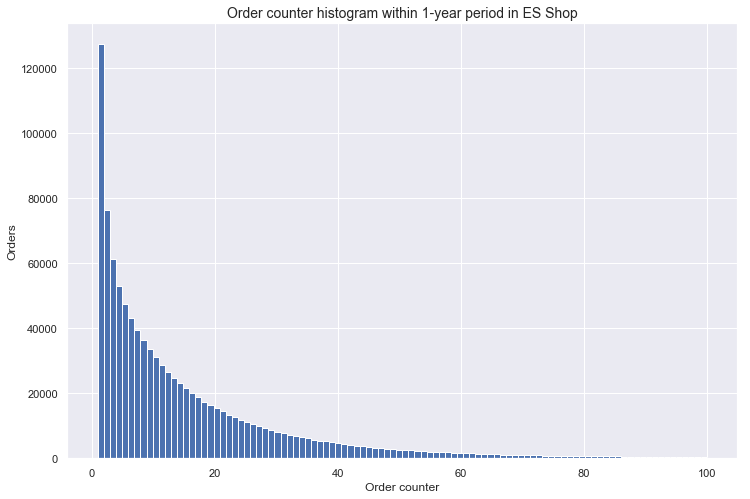

In [127]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(flat_order_counter_list, bins=100, range=(1, 100))
plt.ylabel('Orders')
plt.xlabel('Order counter')
plt.title('Order counter histogram within 1-year period in ES Shop', fontsize=14)
plt.show()

In [ ]:
s = Fitter(flat_order_counter_list, xmin=1, xmax=100, bins=100, verbose=False, timeout=30)
s.fit()
s.summary()

In [ ]:
s.__dict__

In [ ]:
# fatigue life prob dist params (1.5980212366469098, 0.40302423673390453, 6.185848127628459) (shape, loc, scale)

**https://en.wikipedia.org/wiki/Birnbaum%E2%80%93Saunders_distribution**

In [97]:
from scipy.stats import fatiguelife

In [98]:
shape = 1.598
loc = 0.403
scale = 6.186

In [100]:
rv = fatiguelife(shape, loc = loc, scale = scale)

In [101]:
 x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)

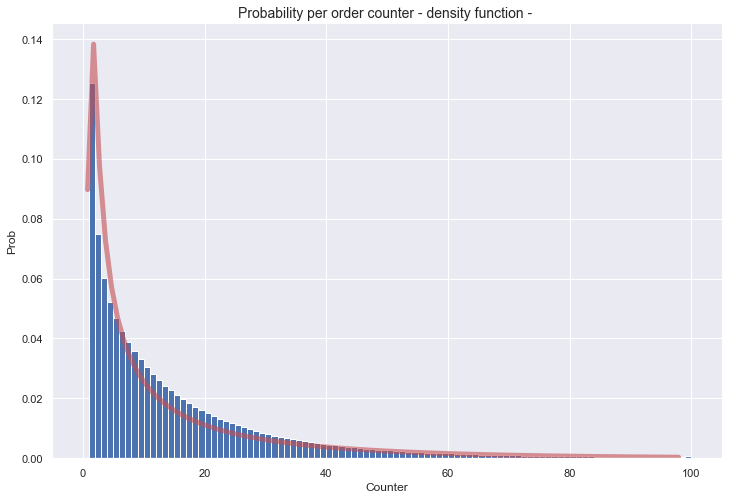

In [144]:
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(flat_order_counter_list, bins=100, range=(0, 100), normed=True)
plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6)
plt.ylabel('Prob')
plt.xlabel('Counter')
plt.title('Probability per order counter - density function - ', fontsize=14)
plt.show()

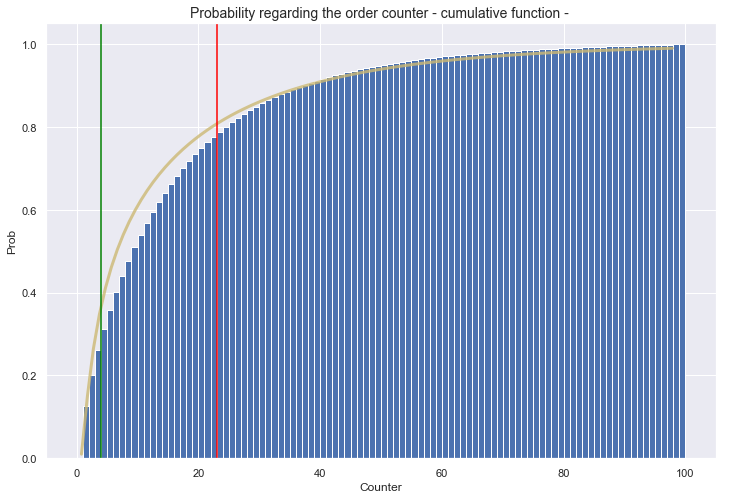

In [151]:
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(flat_order_counter_list, bins=100, range=(0, 100), normed=True, cumulative=True)
plt.plot(x, rv.cdf(x), 'y-', lw=3, alpha=0.8)
plt.ylabel('Prob')
plt.xlabel('Counter')
plt.axvline(x=4, color='green')
plt.axvline(x=23, color='red')
plt.title('Probability regarding the order counter - cumulative function - ', fontsize=14)
plt.show()

In [134]:
for i in range(1, 30):
    print('Delta probability between', i+1, 'orders and ', i, 'is: ', np.round(rv.cdf(i+1) - rv.cdf(i), 4))

Delta probability between 2 orders and  1 is:  0.1461
Delta probability between 3 orders and  2 is:  0.1072
Delta probability between 4 orders and  3 is:  0.078
Delta probability between 5 orders and  4 is:  0.0604
Delta probability between 6 orders and  5 is:  0.049
Delta probability between 7 orders and  6 is:  0.041
Delta probability between 8 orders and  7 is:  0.0352
Delta probability between 9 orders and  8 is:  0.0307
Delta probability between 10 orders and  9 is:  0.0272
Delta probability between 11 orders and  10 is:  0.0243
Delta probability between 12 orders and  11 is:  0.0219
Delta probability between 13 orders and  12 is:  0.0199
Delta probability between 14 orders and  13 is:  0.0182
Delta probability between 15 orders and  14 is:  0.0167
Delta probability between 16 orders and  15 is:  0.0154
Delta probability between 17 orders and  16 is:  0.0143
Delta probability between 18 orders and  17 is:  0.0133
Delta probability between 19 orders and  18 is:  0.0124
Delta probab

If looking at deltas between probability of each order we can see 3 different magnitude orders:

    - Delta > 0.1 | 1-3 orders
    - 0.1 < Delta < 0.01 | 4-22 orders
    - Delta < 0.01 | +23 orders
    
So, at the time of building the scoring we can assign different values depending of the stage in which the customer is

In [3]:
order_count_factors_df = pd.DataFrame([[1, 3, 0.7], [4, 22, 1], [23, '+', 1.2]], columns=['FROM', 'TO', 'FACTOR'])

In [5]:
order_count_factors_df

,FROM,TO,FACTOR
0,1,3,0.7
1,4,22,1.0
2,23,+,1.2


### Performance Score calculation and save dataframe last status

In [96]:
cus_attr.sample(5)

,c_id,lead_ps_per_order,total_sales,orders,order_counter,orders_info,basket_avg,basket_std,lead_ps_ord_sales,main_lead_ps,main_lead_ps_%_ord,main_lead_ps_%_sales,orders_timedeltas,orders_dates,orders_pg3_basket_perc,orders_pg4_share,sales_value_vector,o_counter_factor_vector,sales_value_time_factor_vector
7446581,7446581,"[564379, 564379, 565124, 565124, 458390]",275.93,5,"[15, 16, 17, 18, 19]","[(564379, 63.99), (564379, 59.99), (565124, 72...",55.19,16.49,"[(564379, 2, 123.98), (565124, 2, 101.96000000...",564379,0.4,0.45,"[152, 45, 6, 19]","[2017-07-12, 2017-12-11, 2018-01-25, 2018-01-3...","[[(251, 1.0)], [(251, 1.0)], [(207553, 1.0)], ...","[[(31962, 1.0)], [(31962, 1.0)], [(207615, 1.0...","[63.99, 59.99, 72.48, 29.48, 49.99]","[1, 1, 1, 1, 1]","[0.007, 0.06, 0.12, 0.12, 0.159]"
18845420,18845420,[318838],62.89,1,[1],"[(318838, 62.89)]",62.89,0.00,"[(318838, 1, 62.89)]",318838,1.0,1.00,[],[2017-12-14],"[[(251, 0.954), (0, 0.046)]]","[[(81396, 0.954), (0, 0.046)]]",[62.89],[0.7],[0.069]
18834528,18834528,"[54084, 54084]",103.36,2,"[1, 2]","[(54084, 53.98), (54084, 49.38)]",51.68,3.25,"[(54084, 2, 103.36)]",54084,1.0,1.00,[84],"[2017-12-13, 2018-03-07]","[[(251, 0.852), (0, 0.148)], [(251, 0.931), (0...","[[(682, 0.852), (0, 0.148)], [(682, 0.931), (0...","[53.98, 49.38]","[0.7, 0.7]","[0.069, 0.21]"
19169846,19169846,[331690],74.97,1,[1],"[(331690, 74.97)]",74.97,0.00,"[(331690, 1, 74.97)]",331690,1.0,1.00,[],[2018-01-19],"[[(2190, 0.36), (47, 0.333), (251, 0.307)]]","[[(323, 0.36), (1599, 0.333), (682, 0.307)]]",[74.97],[0.7],[0.105]
12713651,12713651,"[288583, 288583, 288583, 288583, 288583, 28858...",582.70,9,"[17, 18, 19, 20, 21, 22, 23, 24, 25]","[(288583, 62.64), (288583, 79.98), (288583, 39...",64.74,15.97,"[(288583, 9, 582.7)]",288583,1.0,1.00,"[40, 40, 29, 34, 28, 43, 53, 51]","[2017-08-02, 2017-09-11, 2017-10-21, 2017-11-1...","[[(251, 0.638), (252, 0.362), (0, 0.0)], [(251...","[[(71709, 0.638), (201878, 0.362), (0, 0.0)], ...","[62.64, 79.98, 39.99, 79.98, 39.99, 62.58, 79....","[1, 1, 1, 1, 1, 1, 1.2, 1.2, 1.2]","[0.01, 0.017, 0.03, 0.046, 0.079, 0.105, 0.21,..."


In [109]:
cus_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312306 entries, 72564 to 20607579
Data columns (total 19 columns):
c_id                              312306 non-null int64
lead_ps_per_order                 312306 non-null object
total_sales                       312306 non-null float64
orders                            312306 non-null int64
order_counter                     312306 non-null object
orders_info                       312306 non-null object
basket_avg                        312306 non-null float64
basket_std                        312306 non-null float64
lead_ps_ord_sales                 312306 non-null object
main_lead_ps                      312306 non-null int64
main_lead_ps_%_ord                312306 non-null float64
main_lead_ps_%_sales              312260 non-null float64
orders_timedeltas                 312306 non-null object
orders_dates                      312306 non-null object
orders_pg3_basket_perc            312306 non-null object
orders_pg4_share          

We need to compute the product of three vectors: 
    - sales value vector 
    - adjusted sales value over time vector 
    - order counter factor vector
Let´s create them

In [7]:
#Ordered sales value in time from oldest to youngest values
cus_attr['sales_value_vector'] = [[j[1] for j in i] for i in cus_attr['orders_info'].values]

In [128]:
def from_counter_to_factor(x):
    fact_list = []
    for i in x:
        if i >= 23:
            i = 1.1
        elif i >= 4:
            i = 1
        else:
            i = 0.7
        fact_list.append(i)
    return fact_list

In [129]:
from_counter_to_factor([21, 22, 23, 24, 25, 26, 27]), from_counter_to_factor([1, 2, 3, 4, 5, 26, 27])

([1, 1, 1.1, 1.1, 1.1, 1.1, 1.1], [0.7, 0.7, 0.7, 1, 1, 1.1, 1.1])

In [130]:
# Order counter factor vector
cus_attr['o_counter_factor_vector'] = cus_attr['order_counter'].map(from_counter_to_factor)

In [ ]:
# Adjusted sales value over time vector

As our time window gathers all orders from 01/07/2017 to 30/06/2018 let´s establish for the experiment a current date like 01/07/2018 as if we were calculating the score just the day after.

In [131]:
curr_date = pd.to_datetime('2018-07-01', format='%Y-%m-%d')

In [132]:
curr_date.date()

datetime.date(2018, 7, 1)

In [133]:
def from_date_to_factor(x, curr_date):
    fact_list = []
    for date in x:
        td = curr_date.date() - date
        days = td.days
        fact_list_2 = []
        for i, j in list(zip(weighted_values_df['days from order date now'], weighted_values_df['weight'])):
            if len(fact_list_2) == 1:
                continue
            elif days <= i:
                fact_list_2.append(j)
            elif days > 360:
                fact_list_2.append(0.007)
        fact_list.append(fact_list_2[0])
    return fact_list

In [134]:
cus_attr['orders_dates'].iloc[0]

[datetime.date(2017, 7, 11),
 datetime.date(2017, 8, 1),
 datetime.date(2017, 9, 12),
 datetime.date(2017, 11, 11),
 datetime.date(2018, 1, 10),
 datetime.date(2018, 1, 25),
 datetime.date(2018, 2, 20),
 datetime.date(2018, 4, 10),
 datetime.date(2018, 5, 9),
 datetime.date(2018, 6, 28)]

In [135]:
from_date_to_factor(cus_attr['orders_dates'].iloc[0], curr_date)

[0.007, 0.01, 0.017, 0.04, 0.091, 0.12, 0.159, 0.318, 0.483, 0.967]

In [136]:
cus_attr['sales_value_time_factor_vector'] = cus_attr['orders_dates'].apply(from_date_to_factor, curr_date=curr_date)

In [149]:
# Round score function to the closest integer: np.rint()
cus_attr['performance_score'] = [np.rint(sum(np.array(a)*np.array(b)*np.array(c))) for a,b,c in list(zip(cus_attr['sales_value_vector'], 
                                                                                     cus_attr['sales_value_time_factor_vector'],
                                                                                         cus_attr['o_counter_factor_vector']))]

In [150]:
cus_attr.head(5)

,c_id,lead_ps_per_order,total_sales,orders,order_counter,orders_info,basket_avg,basket_std,lead_ps_ord_sales,main_lead_ps,main_lead_ps_%_ord,main_lead_ps_%_sales,orders_timedeltas,orders_dates,orders_pg3_basket_perc,orders_pg4_share,sales_value_vector,o_counter_factor_vector,sales_value_time_factor_vector,performance_score
72564,72564,"[149663, 553298, 521234, 232929, 53453, 510652...",1303.63,10,"[65, 66, 67, 68, 69, 70, 71, 72, 73, 74]","[(149663, 38.34), (553298, 64.47), (521234, 16...",130.36,78.11,"[(521234, 2, 357.76), (232929, 1, 300.04), (51...",521234,0.20,0.27,"[21, 42, 60, 60, 15, 26, 49, 29, 50]","[2017-07-11, 2017-08-01, 2017-09-12, 2017-11-1...","[[(1400, 0.521), (2068, 0.229), (252, 0.182), ...","[[(1412, 0.521), (2079, 0.229), (812, 0.13), (...","[38.34, 64.47, 169.18, 300.04, 98.88, 151.59, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[0.007, 0.01, 0.017, 0.04, 0.091, 0.12, 0.159,...",366.0
124777,124777,[475423],349.66,1,[12],"[(475423, 349.66)]",349.66,0.00,"[(475423, 1, 349.66)]",475423,1.00,1.00,[],[2017-07-05],"[[(18, 0.363), (857, 0.226), (252, 0.114), (20...","[[(948, 0.155), (870, 0.154), (1441, 0.114), (...",[349.66],[1],[0.007],2.0
150255,150255,[53227],102.94,1,[462],"[(53227, 102.94)]",102.94,0.00,"[(53227, 1, 102.94)]",53227,1.00,1.00,[],[2017-07-06],"[[(252, 0.486), (38, 0.194), (2068, 0.175), (0...","[[(683, 0.486), (17262, 0.194), (2083, 0.175),...",[102.94],[1.1],[0.007],1.0
185605,185605,[616872],23.15,1,[46],"[(616872, 23.15)]",23.15,0.00,"[(616872, 1, 23.15)]",616872,1.00,1.00,[],[2017-10-26],"[[(18, 0.483), (409, 0.345), (0, 0.172)]]","[[(1306, 0.483), (413, 0.216), (0, 0.172), (26...",[23.15],[1.1],[0.034],1.0
198539,198539,"[53353, 219176, 53154, 219175]",309.93,4,"[94, 95, 96, 97]","[(53353, 142.4), (219176, 67.32), (53154, 50.7...",77.48,44.04,"[(53353, 1, 142.4), (219176, 1, 67.32), (53154...",53353,0.25,0.46,"[58, 16, 29]","[2018-02-07, 2018-04-06, 2018-04-22, 2018-05-21]","[[(2068, 0.947), (301, 0.105), (0, -0.053)], [...","[[(17871, 0.947), (818, 0.105), (0, -0.053)], ...","[142.4, 67.32, 50.73, 49.48]","[1.1, 1.1, 1.1, 1.1]","[0.138, 0.318, 0.42, 0.555]",99.0


In [153]:
#cus_attr.to_pickle("./es_cus_attr.pkl")

### Performance Score Exploration

In [2]:
cus_attr = pd.read_pickle("./es_cus_attr.pkl")

In [3]:
cus_attr['performance_score'].describe()

count    312306.000000
mean         46.101401
std         109.140062
min         -19.000000
25%           4.000000
50%          20.000000
75%          59.000000
max       40593.000000
Name: performance_score, dtype: float64

In [4]:
list(range(0, 101, 10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [5]:
# % of customer whose score is between 0 and 10
np.round((cus_attr[cus_attr['performance_score'].between(0, 10)]['c_id'].count() / cus_attr['c_id'].count()) * 100, 2)

38.37

In [6]:
# % of customer whose score is between 11 and 100
np.round((cus_attr[cus_attr['performance_score'].between(11, 100)]['c_id'].count() / cus_attr['c_id'].count()) * 100, 2)

48.63

In [7]:
# % of customer whose score is between 101 and 1000
np.round((cus_attr[cus_attr['performance_score'].between(101, 1000)]['c_id'].count() / cus_attr['c_id'].count()) * 100, 2)

12.92

In [8]:
# % of customer whose score is > 1000
np.round((cus_attr[cus_attr['performance_score'] > 1000]['c_id'].count() / cus_attr['c_id'].count()) * 100, 2)

0.06

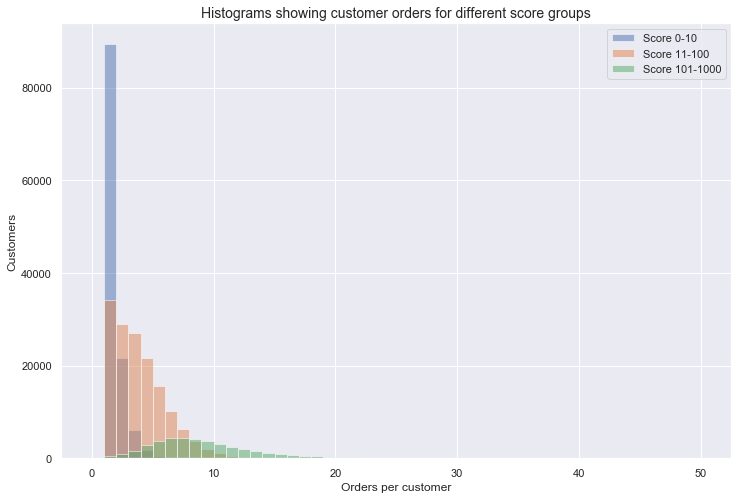

,Score 0-10,Score 11-100,Score 101-1000
count,119817.00,151881.00,40364.00
mean,1.36,3.38,8.93
std,0.72,2.20,5.81
min,1.00,1.00,1.00
25%,1.00,2.00,6.00
50%,1.00,3.00,8.00
75%,2.00,5.00,11.00
max,12.00,82.00,577.00


In [59]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing customer orders for different score groups', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Orders per customer')

for i, j in list(zip([0, 11, 101], [10, 100, 1000])):
    data_cluster = cus_attr[cus_attr['performance_score'].between(i, j)]
    data_cluster['orders'].hist(bins=50, range=(0, 50), alpha=0.5)
    plt.legend(['Score 0-10', 'Score 11-100', 'Score 101-1000'])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_cluster['orders'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Score 0-10', 'Score 11-100', 'Score 101-1000']
display(concat_df)

In [58]:
for i, j in list(zip([0, 11, 101], [10, 100, 1000])):
    data_cluster = cus_attr[cus_attr['performance_score'].between(i, j)]
    print('Percentile of orders = 4 in group with score between', i, ' and', j, ':',
          np.round(stats.percentileofscore(data_cluster['orders'], 4), 2))

Percentile of orders = 4 in group with score between 0  and 10 : 98.63
Percentile of orders = 4 in group with score between 11  and 100 : 66.67
Percentile of orders = 4 in group with score between 101  and 1000 : 10.44


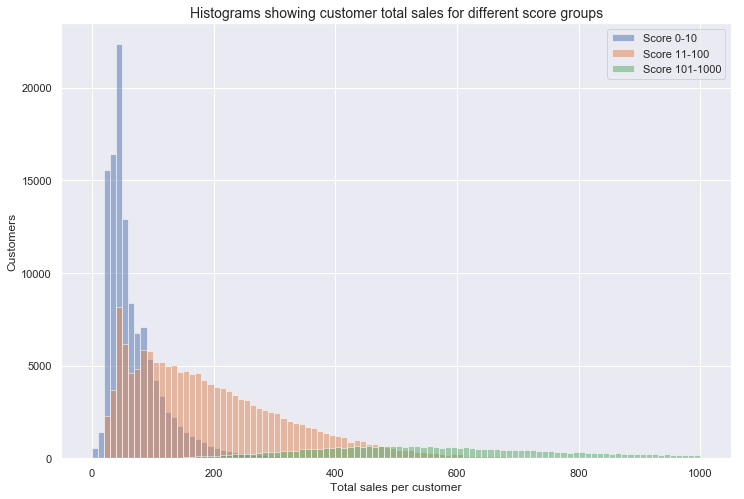

,Score 0-10,Score 11-100,Score 101-1000
count,119817.00,151881.00,40364.00
mean,70.71,201.92,716.17
std,52.68,141.92,507.15
min,-13.75,12.98,98.22
25%,39.58,94.86,438.47
50%,52.94,170.78,598.76
75%,88.14,275.90,836.32
max,1282.49,4846.58,39732.15


In [60]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing customer total sales for different score groups', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Total sales per customer')

for i, j in list(zip([0, 11, 101], [10, 100, 1000])):
    data_cluster = cus_attr[cus_attr['performance_score'].between(i, j)]
    data_cluster['total_sales'].astype(int).hist(bins=100, range=(0, 1000), alpha=0.5)
    plt.legend(['Score 0-10', 'Score 11-100', 'Score 101-1000'])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_cluster['total_sales'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Score 0-10', 'Score 11-100', 'Score 101-1000']
display(concat_df)

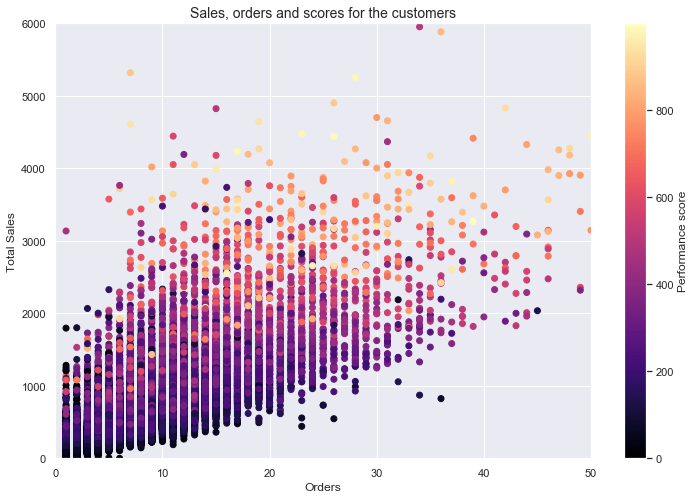

In [61]:
sns.set()
plt.figure(figsize=(12, 8))
plt.scatter(cus_attr[cus_attr['performance_score'].between(0, 1000)]['orders'], 
            cus_attr[cus_attr['performance_score'].between(0, 1000)]['total_sales'],
            c=cus_attr[cus_attr['performance_score'].between(0, 1000)]['performance_score'], alpha=1, cmap='magma')
plt.title('Sales, orders and scores for the customers', fontsize=14)
plt.xlabel('Orders')
plt.xlim(0, 50)
plt.ylim(0, 6000)
plt.ylabel('Total Sales')
plt.colorbar().set_label('Performance score') 

**SUMMARY:**

Percentiles 25% and 75% looking at orders and sales per cluster are:
+ Score 0-10: Orders [1, 2], Sales [40-88€]
+ Score 11-100: Orders [2, 5], Sales [95-276€]
+ Score 101-1000: Orders [6, 11], Sales [438-836€]

**Even more important than the score itself is the ability to store the score values and see how customer deltas are evolving over time...**

In [14]:
for i in list(range(0, 100, 10)):
    print('Customers having a performance score between', i, 'and', i + 9, '(included): ',
          cus_attr[(cus_attr['performance_score'] >= i) & (cus_attr['performance_score'] <= i + 9)]['c_id'].count())
    print('- AVG of orders per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 9)]['orders'].mean(), 2))
    print('- Std dev of orders per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 9)]['orders'].std(), 2))
    print('- AVG of sales per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 9)]['total_sales'].mean(), 2))
    print('- Std dev of sales per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 9)]['total_sales'].std(), 2))

Customers having a performance score between 0 and 9 (included):  115040
- AVG of orders per customer:  1.34
- Std dev of orders per customer:  0.7
- AVG of sales per customer:  69.47
- Std dev of sales per customer:  51.09
Customers having a performance score between 10 and 19 (included):  39046
- AVG of orders per customer:  1.98
- Std dev of orders per customer:  1.21
- AVG of sales per customer:  109.98
- Std dev of sales per customer:  83.43
Customers having a performance score between 20 and 29 (included):  27786
- AVG of orders per customer:  2.47
- Std dev of orders per customer:  1.48
- AVG of sales per customer:  139.37
- Std dev of sales per customer:  98.07
Customers having a performance score between 30 and 39 (included):  21453
- AVG of orders per customer:  3.01
- Std dev of orders per customer:  1.77
- AVG of sales per customer:  172.5
- Std dev of sales per customer:  111.13
Customers having a performance score between 40 and 49 (included):  17145
- AVG of orders per c

In [15]:
for i in list(range(100, 1000, 100)):
    print('Customers having a performance score between', i, 'and', i + 99, '(included): ',
          cus_attr[(cus_attr['performance_score'] >= i) & (cus_attr['performance_score'] <= i + 99)]['c_id'].count())
    print('- AVG of orders per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 99)]['orders'].mean(), 2))
    print('- Std dev of orders per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 99)]['orders'].std(), 2))
    print('- AVG of sales per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 99)]['total_sales'].mean(), 2))
    print('- Std dev of sales per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 99)]['total_sales'].std(), 2))

Customers having a performance score between 100 and 199 (included):  30351
- AVG of orders per customer:  7.55
- Std dev of orders per customer:  3.33
- AVG of sales per customer:  543.09
- Std dev of sales per customer:  215.79
Customers having a performance score between 200 and 299 (included):  6814
- AVG of orders per customer:  10.86
- Std dev of orders per customer:  4.68
- AVG of sales per customer:  922.16
- Std dev of sales per customer:  325.91
Customers having a performance score between 300 and 399 (included):  2113
- AVG of orders per customer:  13.71
- Std dev of orders per customer:  6.17
- AVG of sales per customer:  1314.4
- Std dev of sales per customer:  384.93
Customers having a performance score between 400 and 499 (included):  819
- AVG of orders per customer:  16.55
- Std dev of orders per customer:  20.91
- AVG of sales per customer:  1735.71
- Std dev of sales per customer:  1420.82
Customers having a performance score between 500 and 599 (included):  387
- AV

In [16]:
for i in list(range(1000, 10000, 1000)):
    print('Customers having a performance score between', i, 'and', i + 999, '(included): ',
          cus_attr[(cus_attr['performance_score'] >= i) & (cus_attr['performance_score'] <= i + 999)]['c_id'].count())
    print('- AVG of orders per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 999)]['orders'].mean(), 2))
    print('- Std dev of orders per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 999)]['orders'].std(), 2))
    print('- AVG of sales per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 999)]['total_sales'].mean(), 2))
    print('- Std dev of sales per customer: ', np.round(cus_attr[(cus_attr['performance_score'] >= i) &
                                                         (cus_attr['performance_score'] <= i + 999)]['total_sales'].std(), 2))

Customers having a performance score between 1000 and 1999 (included):  147
- AVG of orders per customer:  33.99
- Std dev of orders per customer:  21.08
- AVG of sales per customer:  5141.73
- Std dev of sales per customer:  1490.51
Customers having a performance score between 2000 and 2999 (included):  23
- AVG of orders per customer:  53.74
- Std dev of orders per customer:  35.62
- AVG of sales per customer:  9310.16
- Std dev of sales per customer:  3625.78
Customers having a performance score between 3000 and 3999 (included):  3
- AVG of orders per customer:  61.33
- Std dev of orders per customer:  29.69
- AVG of sales per customer:  12663.85
- Std dev of sales per customer:  4189.84
Customers having a performance score between 4000 and 4999 (included):  5
- AVG of orders per customer:  62.2
- Std dev of orders per customer:  23.24
- AVG of sales per customer:  15245.93
- Std dev of sales per customer:  6339.44
Customers having a performance score between 5000 and 5999 (included

## 'Discount logic' parameters 

### PG3-PG4 time series

In [3]:
query = """select pg_id, pg_parent_pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_parent_pg_id in (2, 3, 4, 5, 6)
order by pg_id"""

In [4]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [5]:
pg3

,PG_ID,PG_PARENT_PG_ID,PG_SHORTLINK
0,7,2,welpen
1,9,2,hundebett
2,11,2,hygiene_und_bekleidung
3,15,2,hundeleine_hundehalsband
4,16,2,fressnapf
5,17,2,hunde_boutique
6,18,2,hundesnacks
7,20,2,hundespielzeug
8,21,2,hunde_reisen
9,22,2,vitamine_und_gesundes


**Profile example 1**

In [6]:
cus_attr.loc[16545049]

c_id                                                                       16545049
lead_ps_per_order                 [565124, 480395, 618331, 621989, 516002, 67654...
total_sales                                                                  648.87
orders                                                                            9
order_counter                                         [3, 4, 5, 6, 7, 8, 9, 10, 11]
orders_info                       [(565124, 104.97), (480395, 93.5), (618331, 77...
basket_avg                                                                     72.1
basket_std                                                                    26.16
lead_ps_ord_sales                 [(565124, 1, 104.97), (591107, 1, 94.66), (480...
main_lead_ps                                                                 565124
main_lead_ps_%_ord                                                             0.11
main_lead_ps_%_sales                                                        

In [7]:
cus_attr.loc[16545049]['orders_pg3_basket_perc']

[[(207553, 0.914), (409, 0.086)],
 [(23, 0.481),
  (29, 0.195),
  (1540, 0.139),
  (2068, 0.08),
  (252, 0.064),
  (301, 0.061),
  (16, 0.032),
  (0, -0.053)],
 [(2068, 0.361),
  (301, 0.176),
  (36, 0.116),
  (2155, 0.116),
  (252, 0.09),
  (409, 0.077),
  (34, 0.032),
  (16, 0.032)],
 [(301, 0.413), (36, 0.402), (252, 0.185), (0, 0.0)],
 [(207553, 0.4), (33, 0.278), (2068, 0.25), (36, 0.072)],
 [(2068, 0.414), (252, 0.295), (301, 0.202), (34, 0.089)],
 [(252, 0.439), (9, 0.293), (36, 0.268)],
 [(301, 0.63), (2068, 0.191), (33, 0.178), (0, 0.0)],
 [(251, 0.496), (1400, 0.264), (2068, 0.123), (252, 0.116), (0, 0.0)]]

**Profile example 2**

In [8]:
cus_attr.loc[8669346]

c_id                                                                        8669346
lead_ps_per_order                 [54049, 327553, 341914, 140985, 124448, 54049,...
total_sales                                                                  1794.7
orders                                                                            9
order_counter                                  [14, 15, 16, 17, 18, 19, 20, 21, 22]
orders_info                       [(54049, 218.81), (327553, 258.19), (341914, 5...
basket_avg                                                                   199.41
basket_std                                                                    71.16
lead_ps_ord_sales                 [(54049, 2, 345.59000000000003), (341914, 2, 2...
main_lead_ps                                                                  54049
main_lead_ps_%_ord                                                             0.22
main_lead_ps_%_sales                                                        

In [9]:
cus_attr.loc[8669346]['orders_pg3_basket_perc']

[[(251, 0.425), (20, 0.251), (207553, 0.215), (18, 0.162), (0, -0.053)],
 [(20, 0.379),
  (251, 0.349),
  (305, 0.132),
  (153317, 0.124),
  (409, 0.043),
  (29, 0.027),
  (0, -0.053)],
 [(251, 1.053), (0, -0.053)],
 [(251, 0.684), (18, 0.322), (38, 0.047), (0, -0.053)],
 [(251, 1.053), (0, -0.053)],
 [(251, 0.749), (207553, 0.201), (18, 0.102), (0, -0.053)],
 [(251, 0.672), (18, 0.276), (50, 0.105), (0, -0.053)],
 [(251, 0.723),
  (1400, 0.103),
  (20, 0.089),
  (18, 0.055),
  (153317, 0.034),
  (50, 0.028),
  (409, 0.021),
  (0, -0.053)],
 [(251, 0.399), (18, 0.313), (207553, 0.214), (153317, 0.126), (0, -0.053)]]

In [10]:
cus_attr.loc[8669346]['orders_pg4_share']

[[(465, 0.251),
  (754, 0.219),
  (207615, 0.215),
  (118221, 0.206),
  (394, 0.089),
  (250154, 0.073),
  (0, -0.053)],
 [(72745, 0.349),
  (530, 0.132),
  (153275, 0.124),
  (48299, 0.122),
  (108, 0.11),
  (350, 0.054),
  (465, 0.043),
  (413, 0.043),
  (1428, 0.031),
  (1082, 0.027),
  (168571, 0.019),
  (0, -0.053)],
 [(18245, 1.053), (0, -0.053)],
 [(18245, 0.684), (394, 0.322), (1562, 0.047), (0, -0.053)],
 [(754, 0.545), (118221, 0.507), (0, -0.053)],
 [(754, 0.379),
  (118221, 0.371),
  (207615, 0.201),
  (250154, 0.102),
  (0, -0.053)],
 [(18245, 0.672), (394, 0.276), (161, 0.067), (276, 0.038), (0, -0.053)],
 [(18245, 0.723),
  (1411, 0.103),
  (250154, 0.055),
  (48299, 0.045),
  (465, 0.045),
  (153319, 0.034),
  (276, 0.028),
  (2613, 0.021),
  (0, -0.053)],
 [(2051, 0.399),
  (207615, 0.214),
  (394, 0.193),
  (153321, 0.126),
  (250154, 0.12),
  (0, -0.053)]]

**Profile example 3**

In [11]:
cus_attr.loc[16870176]

c_id                                                                       16870176
lead_ps_per_order                 [390724, 473918, 473918, 473918, 390724, 47391...
total_sales                                                                  463.35
orders                                                                           10
order_counter                                    [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
orders_info                       [(390724, 42.16), (473918, 57.66), (473918, 43...
basket_avg                                                                    46.34
basket_std                                                                     9.86
lead_ps_ord_sales                 [(473918, 5, 251.5), (390724, 2, 90.41), (4834...
main_lead_ps                                                                 473918
main_lead_ps_%_ord                                                              0.5
main_lead_ps_%_sales                                                        

In [12]:
cus_attr.loc[16870176]['orders_pg3_basket_perc']

[[(252, 0.489), (2068, 0.483), (34, 0.028)],
 [(2068, 0.581), (252, 0.399), (34, 0.021)],
 [(252, 0.525), (2068, 0.475)],
 [(2068, 0.568), (252, 0.432)],
 [(2068, 1.0)],
 [(252, 0.578), (2068, 0.321), (34, 0.1)],
 [(2068, 0.597), (252, 0.403)],
 [(252, 0.625), (2068, 0.375)],
 [(252, 0.922), (2068, 0.048), (34, 0.03)],
 [(2068, 0.834), (0, 0.166)]]

In [13]:
cus_attr.loc[16870176]['orders_pg4_share']

[[(31963, 0.489), (2073, 0.426), (39209, 0.056), (71979, 0.028)],
 [(720, 0.399), (2072, 0.303), (2073, 0.277), (71978, 0.021)],
 [(720, 0.525), (2073, 0.388), (9498, 0.087)],
 [(720, 0.432), (2072, 0.328), (2073, 0.169), (9498, 0.071)],
 [(2073, 0.559), (2072, 0.362), (9498, 0.079)],
 [(720, 0.578), (2073, 0.226), (71979, 0.1), (9498, 0.095)],
 [(720, 0.403), (2072, 0.307), (2073, 0.158), (9498, 0.133)],
 [(31963, 0.625), (2073, 0.375)],
 [(31963, 0.922), (39209, 0.048), (1559, 0.03)],
 [(39209, 0.834), (0, 0.166)]]

In [29]:
cus_attr.tail(5)

,c_id,lead_ps_per_order,total_sales,orders,order_counter,orders_info,basket_avg,basket_std,lead_ps_ord_sales,main_lead_ps,main_lead_ps_%_ord,main_lead_ps_%_sales,orders_timedeltas,orders_dates,orders_pg3_basket_perc,orders_pg4_share,sales_value_vector,o_counter_factor_vector,sales_value_time_factor_vector,performance_score
20607458,20607458,[565124],53.87,1,[1],"[(565124, 53.87)]",53.87,0.0,"[(565124, 1, 53.87)]",565124,1.0,1.0,[],[2018-06-30],"[[(207553, 0.482), (15, 0.241), (20, 0.223), (...","[[(207615, 0.482), (16637, 0.241), (465, 0.223...",[53.87],[0.7],[0.967],36.0
20607495,20607495,[527593],44.96,1,[1],"[(527593, 44.96)]",44.96,0.0,"[(527593, 1, 44.96)]",527593,1.0,1.0,[],[2018-06-30],"[[(252, 0.578), (301, 0.333), (0, 0.044), (36,...","[[(81431, 0.578), (10331, 0.333), (0, 0.044), ...",[44.96],[0.7],[0.967],30.0
20607549,20607549,[394379],52.89,1,[1],"[(394379, 52.89)]",52.89,0.0,"[(394379, 1, 52.89)]",394379,1.0,1.0,[],[2018-06-30],"[[(251, 0.945), (0, 0.055)]]","[[(18245, 0.945), (0, 0.055)]]",[52.89],[0.7],[0.967],36.0
20607555,20607555,[185819],68.76,1,[1],"[(185819, 68.76)]",68.76,0.0,"[(185819, 1, 68.76)]",185819,1.0,1.0,[],[2018-06-30],"[[(29, 0.392), (252, 0.349), (409, 0.116), (23...","[[(128, 0.349), (683, 0.349), (99055, 0.116), ...",[68.76],[0.7],[0.967],47.0
20607579,20607579,[649649],86.40,1,[1],"[(649649, 86.4)]",86.40,0.0,"[(649649, 1, 86.4)]",649649,1.0,1.0,[],[2018-06-30],"[[(29, 0.197), (301, 0.173), (1540, 0.162), (3...","[[(10331, 0.173), (1085, 0.173), (1555, 0.162)...",[86.4],[0.7],[0.967],58.0


In [ ]:
# Find relationships between lead_ps and order counter

In [20]:
lead_ps_all = [j for i in cus_attr['lead_ps_per_order'].values for j in i]

In [23]:
order_counter_all = [j for i in cus_attr['order_counter'].values for j in i]

In [31]:
order_counter_all[::-1][:5]

[1, 1, 1, 1, 1]

In [32]:
lead_ps_all[::-1][:5]

[649649, 185819, 394379, 527593, 565124]

In [28]:
len(lead_ps_all) == len(order_counter_all)

True

In [33]:
lead_ps_order_counter = [(i, j) for i, j in list(zip(lead_ps_all, order_counter_all))]

In [35]:
cus_attr.head()

,c_id,lead_ps_per_order,total_sales,orders,order_counter,orders_info,basket_avg,basket_std,lead_ps_ord_sales,main_lead_ps,main_lead_ps_%_ord,main_lead_ps_%_sales,orders_timedeltas,orders_dates,orders_pg3_basket_perc,orders_pg4_share,sales_value_vector,o_counter_factor_vector,sales_value_time_factor_vector,performance_score
72564,72564,"[149663, 553298, 521234, 232929, 53453, 510652...",1303.63,10,"[65, 66, 67, 68, 69, 70, 71, 72, 73, 74]","[(149663, 38.34), (553298, 64.47), (521234, 16...",130.36,78.11,"[(521234, 2, 357.76), (232929, 1, 300.04), (51...",521234,0.20,0.27,"[21, 42, 60, 60, 15, 26, 49, 29, 50]","[2017-07-11, 2017-08-01, 2017-09-12, 2017-11-1...","[[(1400, 0.521), (2068, 0.229), (252, 0.182), ...","[[(1412, 0.521), (2079, 0.229), (812, 0.13), (...","[38.34, 64.47, 169.18, 300.04, 98.88, 151.59, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[0.007, 0.01, 0.017, 0.04, 0.091, 0.12, 0.159,...",366.0
124777,124777,[475423],349.66,1,[12],"[(475423, 349.66)]",349.66,0.00,"[(475423, 1, 349.66)]",475423,1.00,1.00,[],[2017-07-05],"[[(18, 0.363), (857, 0.226), (252, 0.114), (20...","[[(948, 0.155), (870, 0.154), (1441, 0.114), (...",[349.66],[1],[0.007],2.0
150255,150255,[53227],102.94,1,[462],"[(53227, 102.94)]",102.94,0.00,"[(53227, 1, 102.94)]",53227,1.00,1.00,[],[2017-07-06],"[[(252, 0.486), (38, 0.194), (2068, 0.175), (0...","[[(683, 0.486), (17262, 0.194), (2083, 0.175),...",[102.94],[1.1],[0.007],1.0
185605,185605,[616872],23.15,1,[46],"[(616872, 23.15)]",23.15,0.00,"[(616872, 1, 23.15)]",616872,1.00,1.00,[],[2017-10-26],"[[(18, 0.483), (409, 0.345), (0, 0.172)]]","[[(1306, 0.483), (413, 0.216), (0, 0.172), (26...",[23.15],[1.1],[0.034],1.0
198539,198539,"[53353, 219176, 53154, 219175]",309.93,4,"[94, 95, 96, 97]","[(53353, 142.4), (219176, 67.32), (53154, 50.7...",77.48,44.04,"[(53353, 1, 142.4), (219176, 1, 67.32), (53154...",53353,0.25,0.46,"[58, 16, 29]","[2018-02-07, 2018-04-06, 2018-04-22, 2018-05-21]","[[(2068, 0.947), (301, 0.105), (0, -0.053)], [...","[[(17871, 0.947), (818, 0.105), (0, -0.053)], ...","[142.4, 67.32, 50.73, 49.48]","[1.1, 1.1, 1.1, 1.1]","[0.138, 0.318, 0.42, 0.555]",99.0


In [36]:
lead_ps_order_counter[:17]

[(149663, 65),
 (553298, 66),
 (521234, 67),
 (232929, 68),
 (53453, 69),
 (510652, 70),
 (293440, 71),
 (464741, 72),
 (171528, 73),
 (521234, 74),
 (475423, 12),
 (53227, 462),
 (616872, 46),
 (53353, 94),
 (219176, 95),
 (53154, 96),
 (219175, 97)]

In [37]:
lead_ps_order_count_counter = Counter(lead_ps_order_counter)

In [38]:
lead_ps_order_count_counter.most_common()

[((565124, 1), 3785),
 ((425560, 1), 2486),
 ((531461, 1), 1948),
 ((565124, 2), 1645),
 ((53219, 1), 1451),
 ((425560, 2), 1319),
 ((547201, 1), 1273),
 ((53219, 5), 1214),
 ((53219, 3), 1203),
 ((53219, 4), 1200),
 ((53219, 6), 1187),
 ((53219, 2), 1169),
 ((53219, 7), 1109),
 ((565124, 3), 1085),
 ((53219, 8), 1078),
 ((54742, 1), 1062),
 ((53228, 1), 1043),
 ((53219, 9), 1031),
 ((1, 1), 1021),
 ((111463, 1), 1021),
 ((148394, 1), 999),
 ((425560, 3), 932),
 ((53219, 10), 924),
 ((54084, 1), 875),
 ((318838, 1), 859),
 ((53228, 2), 835),
 ((53219, 11), 834),
 ((565124, 4), 834),
 ((54079, 1), 815),
 ((53219, 12), 801),
 ((473915, 1), 750),
 ((53219, 13), 731),
 ((53219, 14), 720),
 ((425560, 4), 697),
 ((565124, 5), 652),
 ((53219, 15), 643),
 ((53228, 3), 633),
 ((473915, 2), 600),
 ((564379, 1), 575),
 ((54079, 2), 571),
 ((53219, 16), 564),
 ((565124, 6), 564),
 ((54089, 1), 564),
 ((425560, 5), 559),
 ((188251, 1), 554),
 ((53219, 17), 552),
 ((318838, 2), 549),
 ((185645, 1), 

In [40]:
# Select those customers having placed at least 4 within the time window
mask_4_orders = [len(i) >= 4 for i in cus_attr['order_counter'].values]

In [41]:
cus_attr[mask_4_orders]

,c_id,lead_ps_per_order,total_sales,orders,order_counter,orders_info,basket_avg,basket_std,lead_ps_ord_sales,main_lead_ps,main_lead_ps_%_ord,main_lead_ps_%_sales,orders_timedeltas,orders_dates,orders_pg3_basket_perc,orders_pg4_share,sales_value_vector,o_counter_factor_vector,sales_value_time_factor_vector,performance_score
72564,72564,"[149663, 553298, 521234, 232929, 53453, 510652...",1303.63,10,"[65, 66, 67, 68, 69, 70, 71, 72, 73, 74]","[(149663, 38.34), (553298, 64.47), (521234, 16...",130.36,78.11,"[(521234, 2, 357.76), (232929, 1, 300.04), (51...",521234,0.20,0.27,"[21, 42, 60, 60, 15, 26, 49, 29, 50]","[2017-07-11, 2017-08-01, 2017-09-12, 2017-11-1...","[[(1400, 0.521), (2068, 0.229), (252, 0.182), ...","[[(1412, 0.521), (2079, 0.229), (812, 0.13), (...","[38.34, 64.47, 169.18, 300.04, 98.88, 151.59, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[0.007, 0.01, 0.017, 0.04, 0.091, 0.12, 0.159,...",366.0
198539,198539,"[53353, 219176, 53154, 219175]",309.93,4,"[94, 95, 96, 97]","[(53353, 142.4), (219176, 67.32), (53154, 50.7...",77.48,44.04,"[(53353, 1, 142.4), (219176, 1, 67.32), (53154...",53353,0.25,0.46,"[58, 16, 29]","[2018-02-07, 2018-04-06, 2018-04-22, 2018-05-21]","[[(2068, 0.947), (301, 0.105), (0, -0.053)], [...","[[(17871, 0.947), (818, 0.105), (0, -0.053)], ...","[142.4, 67.32, 50.73, 49.48]","[1.1, 1.1, 1.1, 1.1]","[0.138, 0.318, 0.42, 0.555]",99.0
266476,266476,"[327495, 600818, 147968, 576601, 665669, 52712...",3183.16,18,"[271, 272, 273, 274, 275, 276, 277, 278, 279, ...","[(327495, 262.67), (600818, 125.35), (147968, ...",176.84,57.86,"[(327495, 5, 1100.98), (690416, 4, 722.78), (1...",327495,0.28,0.35,"[6, 9, 21, 4, 13, 13, 11, 27, 15, 8, 7, 19, 14...","[2017-10-16, 2017-10-22, 2017-10-31, 2017-11-2...","[[(2068, 0.548), (301, 0.365), (29, 0.198), (0...","[[(2632, 0.365), (3243, 0.365), (128, 0.198), ...","[262.67, 125.35, 104.31, 211.46, 91.26, 146.57...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[0.03, 0.03, 0.034, 0.046, 0.052, 0.06, 0.069,...",766.0
364257,364257,"[409439, 485008, 611442, 409439, 556957, 40943...",1222.75,17,"[127, 128, 129, 130, 131, 132, 133, 134, 135, ...","[(409439, 48.95), (485008, 130.89), (611442, 8...",71.93,28.17,"[(589075, 6, 345.43), (409439, 3, 211.84), (63...",589075,0.35,0.28,"[31, 28, 23, 8, 29, 15, 14, 35, 29, 30, 12, 15...","[2017-07-09, 2017-08-09, 2017-09-06, 2017-09-2...","[[(2068, 0.888), (38, 0.143), (0, -0.031)], [(...","[[(2071, 0.531), (2072, 0.357), (139, 0.143), ...","[48.95, 130.89, 82.14, 68.35, 77.57, 94.54, 39...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[0.007, 0.011, 0.017, 0.023, 0.026, 0.04, 0.04...",276.0
408850,408850,"[216629, 169704, 477191, 635536]",167.21,4,"[40, 41, 42, 43]","[(216629, 46.03), (169704, 40.72), (477191, 41...",41.80,3.07,"[(216629, 1, 46.03), (477191, 1, 41.68), (1697...",216629,0.25,0.28,"[121, 4, 32]","[2017-10-23, 2018-02-21, 2018-02-25, 2018-03-29]","[[(9, 0.803), (40023, 0.174), (409, 0.054), (0...","[[(30936, 0.652), (43419, 0.174), (74, 0.152),...","[46.03, 40.72, 41.68, 38.78]","[1.1, 1.1, 1.1, 1.1]","[0.03, 0.183, 0.183, 0.277]",30.0
414230,414230,"[641681, 565124, 53991, 341448, 626201, 325904...",793.76,11,"[76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87]","[(641681, 49.86), (565124, 79.14), (53991, 102...",72.16,34.42,"[(565124, 2, 158.31), (541430, 1, 158.4), (539...",565124,0.18,0.20,"[75, 22, 10, 33, 21, 19, 60, 40, 39, 30]","[2017-07-02, 2017-09-15, 2017-10-07, 2017-10-1...","[[(18, 0.956), (401, 0.075), (0, -0.031)], [(2...","[[(101, 0.394), (394, 0.202), (2595, 0.2), (14...","[49.86, 79.14, 102.78, 52.79, 41.67, 39.71, 50...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[0.007, 0.02, 0.026, 0.03, 0.046, 0.06, 0.079,...",187.0
438391,438391,"[310748, 520605, 520605, 520605]",230.56,4,"[7, 8, 9, 10]","[(310748, 119.92), (520605, 43.39), (520605, 3...",57.64,41.77,"[(520605, 3, 110.64000000000001), (310748, 1, ...",520605,0.75,0.48,"[18, 24, 29]","[2018-04-02, 2018-04-20, 20

In [42]:
cus_attr['c_id'].nunique()

312306

## Repurchasing aspects

### Get timedeltas between any lead_PS_ID and the next order

Involving timedelta until next order it would be desirable working at the **LEAD_PS_ID VARIANT** level

#### Get flat list of every lead_PS_ID in the dataframe and built the dictionary (key=lead_ps_id, value=list of timedeltas until next order)

In [16]:
set_lead_ps_id = set([j for i in cus_attr['lead_ps_per_order'].values for j in i])

In [17]:
len(set_lead_ps_id)

6673

In [47]:
td_dict_per_lead_ps = {i:[td[n] for list_lead_ps_per_order, td in list(zip(cus_attr['lead_ps_per_order'], cus_attr['orders_timedeltas']))
                                if len(list_lead_ps_per_order) > 1 for n, lead_ps in enumerate(list_lead_ps_per_order[:-1])
                                if i == lead_ps] for i in list(set_lead_ps_id)}

In [48]:
len(td_dict_per_lead_ps)

6673

In [54]:
#with open('es_td_dict_per_lead_ps.p', 'wb') as fp:
#    pickle.dump(td_dict_per_lead_ps, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('es_td_dict_per_lead_ps.p', 'rb') as fp:
    td_dict_per_lead_ps = pickle.load(fp)

#### Example with RC Sterilised 37 | PS_ID: 53219

In [56]:
# RC Sterilised 37
rc_st_37_test = td_dict_per_lead_ps[53219]

In [57]:
len(rc_st_37_test)

17815

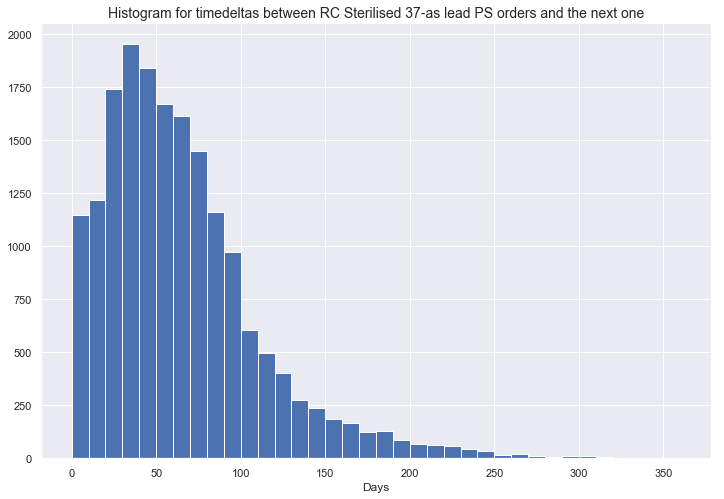

In [58]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(rc_st_37_test, bins=36, range=(0, 360))
plt.xlabel('Days')
plt.title('Histogram for timedeltas between RC Sterilised 37-as lead PS orders and the next one', fontsize=14)
plt.show()

,sumsquare_error
mielke,0.000011
ncx2,0.000015
gumbel_r,0.000017
genlogistic,0.000017
exponweib,0.000017


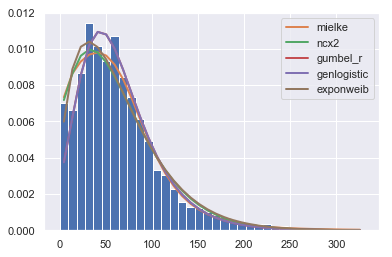

In [59]:
f = Fitter(rc_st_37_test, xmin=0, xmax=360, bins=36, verbose=False, timeout=30)
f.fit()
f.summary()

In [60]:
f.__dict__

{'_alldata': array([79, 76, 99, ...,  2,  1,  5]),
 '_data': array([79, 76, 99, ...,  2,  1,  5]),
 '_fitted_errors': {'alpha': 0.0036237091310683403,
  'anglit': 0.00041803320378079595,
  'arcsine': 0.00045700375504766213,
  'argus': 0.0005612416043897357,
  'beta': 1.7563437581170555e-05,
  'betaprime': 1.8095382201624515e-05,
  'bradford': 0.00022321661460955575,
  'burr': 1.856079060438037e-05,
  'burr12': 0.00010603192225752297,
  'cauchy': 8.325390666531415e-05,
  'chi': 2.8399725761708493e-05,
  'chi2': 0.003189382944295013,
  'cosine': 0.0003343169986138128,
  'crystalball': 7.942266949789851e-05,
  'dgamma': 5.0410870804449565e-05,
  'dweibull': 4.426026980164848e-05,
  'erlang': 0.0008610619880833645,
  'expon': 0.0001535987654633441,
  'exponnorm': 2.6404081832481424e-05,
  'exponpow': 8.549802109298646e-05,
  'exponweib': 1.7242640832248356e-05,
  'f': 1.758846231919221e-05,
  'fatiguelife': 1.835449367422936e-05,
  'fisk': 0.0009520782383919874,
  'foldcauchy': 0.002323849

#### Iterate over the lead_ps dictionary finding the best-fitting probability distribution for each 


As we have 6673 different lead_ps let's get only those having at least 150 timedelta values for fitting the histogram to a probability distribution...

In [65]:
subset = [i for i in list(td_dict_per_lead_ps.keys()) if len(td_dict_per_lead_ps[i]) > 150]

In [66]:
# 885 lead_ps matching the criteria...
len(subset)

885

In [68]:
# we provide a subset of 14 distributions for fitting (by default, the function tries over more than 80)
prob_dist = ['beta', 'burr', 'dgamma', 'gamma', 'invgamma', 'dweibull', 'loggamma', 'lognorm', 
             'rayleigh', 'fatiguelife', 'invgauss', 'invweibull', 'mielke', 'genlogistic']

In [69]:
lead_ps_td_best_dist = {}

In [70]:
for i in subset:
    f = Fitter(td_dict_per_lead_ps[i], xmin=0, xmax=360, bins=36, verbose=False, timeout=30, distributions=prob_dist)
    f.fit() 
    best_dist = f.df_errors.sort_values('sumsquare_error').iloc[0].name
    lead_ps_td_best_dist[i] = {}
    lead_ps_td_best_dist[i][best_dist] = f.fitted_param[best_dist]
    lead_ps_td_best_dist[i]['error'] = np.round(f.df_errors.sort_values('sumsquare_error').iloc[0].values[0], 4)
    lead_ps_td_best_dist[i]['sample_len'] = len(td_dict_per_lead_ps[i])

In [71]:
# Must match with RC Sterilised 37 example -same data-
lead_ps_td_best_dist[53219]

{'error': 0.0,
 'mielke': (1.1570069068754918,
  3.9278410964929398,
  -0.4082483711718601,
  98.7072339177429),
 'sample_len': 17815}

In [72]:
#with open('es_lead_ps_td_best_dist.p', 'wb') as fp:
#    pickle.dump(lead_ps_td_best_dist, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('es_lead_ps_td_best_dist.p', 'rb') as fp:
    lead_ps_td_best_dist = pickle.load(fp)

In [73]:
#Pandas DataFrame
lead_ps_td_best_dist_df = pd.DataFrame.from_dict(lead_ps_td_best_dist, orient='index')

In [75]:
lead_ps_td_best_dist_df.fillna('-').head()

,mielke,error,sample_len,invweibull,invgauss,gamma,beta,burr,fatiguelife,invgamma,dgamma,lognorm,genlogistic,dweibull,rayleigh
1,"(5.644102775841145, 1.60440629803964, -2.71340...",0.0001,2711,-,-,-,-,-,-,-,-,-,-,-,-
52634,-,0.0001,153,-,-,-,"(0.8775319577308176, 3.1670958860589415, -2.61...",-,-,-,-,-,-,-,-
52865,"(84.98010665449922, 3.9585603745037616, -77.26...",0.0000,402,-,-,-,-,-,-,-,-,-,-,-,-
53154,-,0.0000,522,-,-,-,-,-,"(0.6865521131498246, -12.373369243488735, 59.6...",-,-,-,-,-,-
53155,-,0.0001,211,-,-,-,-,"(3.8723045368175413, 0.2625802761705034, -0.04...",-,-,-,-,-,-,-


In [76]:
lead_ps_td_best_dist_df['error'].describe()

count    885.000000
mean       0.000075
std        0.000142
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000100
max        0.002400
Name: error, dtype: float64

In [78]:
lead_ps_td_best_dist_df['sample_len'].describe()

count      885.000000
mean       675.566102
std        994.360830
min        151.000000
25%        223.000000
50%        359.000000
75%        730.000000
max      17815.000000
Name: sample_len, dtype: float64

In [79]:
lead_ps_td_best_dist_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 1 to 686161
Data columns (total 15 columns):
mielke         193 non-null object
error          885 non-null float64
sample_len     885 non-null int64
invweibull     33 non-null object
invgauss       51 non-null object
gamma          83 non-null object
beta           56 non-null object
burr           167 non-null object
fatiguelife    89 non-null object
invgamma       42 non-null object
dgamma         40 non-null object
lognorm        42 non-null object
genlogistic    53 non-null object
dweibull       31 non-null object
rayleigh       5 non-null object
dtypes: float64(1), int64(1), object(13)
memory usage: 110.6+ KB


**https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.burr.html**

**https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mielke.html**